In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hyperspectral-blueberries/Good Blueberry 169-210.bil.hdr
/kaggle/input/hyperspectral-blueberries/Bad Blueberries 1-42.bil
/kaggle/input/hyperspectral-blueberries/Bad Blueberries 127-168.bil
/kaggle/input/hyperspectral-blueberries/Good Blueberry 127-168.bil
/kaggle/input/hyperspectral-blueberries/Good Blueberry 85-126.bil.hdr
/kaggle/input/hyperspectral-blueberries/WhiteReference.bil.hdr
/kaggle/input/hyperspectral-blueberries/WhiteReference.bil
/kaggle/input/hyperspectral-blueberries/Bad Blueberry 43-84.bil.hdr
/kaggle/input/hyperspectral-blueberries/Bad Blueberry 85-126.bil.hdr
/kaggle/input/hyperspectral-blueberries/Good Blueberry 127-168.bil.hdr
/kaggle/input/hyperspectral-blueberries/Good Blueberry 43-84.bil.hdr
/kaggle/input/hyperspectral-blueberries/Bad Blueberries 169-210.bil
/kaggle/input/hyperspectral-blueberries/Good Blueberry 1-42.bil
/kaggle/input/hyperspectral-blueberries/Bad Blueberries 169-210.bil.hdr
/kaggle/input/hyperspectral-blueberries/Bad Blueberries 

In [2]:
!pip install spectral numpy pandas matplotlib seaborn scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 3.7 MB/s eta 0:00:00a 0:00:01


In [3]:
import numpy as np
import spectral.io.envi as envi
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns

In [4]:
# Load a BIL file and its corresponding header file.
def load_bil_file(bil_path, hdr_path=None):
    if hdr_path is None:
        hdr_path = bil_path + '.hdr'
    
    try:
        # Load the hyperspectral data
        img = envi.open(hdr_path, bil_path)
        data = img.load()
        return data
    except Exception as e:
        print(f"Error loading file {bil_path}: {str(e)}")
        return None

In [5]:
#Select a region of interest from the hyperspectral data.
def select_roi(data, x_start, y_start, width, height):    
    return data[y_start:y_start+height, x_start:x_start+width, :]

In [6]:
# Extract spectral features from the ROI data.
def extract_spectral_features(roi_data):
    # Average spectrum across spatial dimensions
    mean_spectrum = np.mean(roi_data, axis=(0, 1))
    
    # Calculate additional features
    max_intensity = np.max(roi_data, axis=2)
    min_intensity = np.min(roi_data, axis=2)
    
    return {
        'mean_spectrum': mean_spectrum,
        'max_intensity': max_intensity,
        'min_intensity': min_intensity
    }

In [7]:
#Analyze the baseline characteristics of the dataset.
def analyze_baseline(data_path):
    # Dictionary to store results
    results = {
        'good': [],
        'bad': []
    }
    
    # Process all files
    for filename in os.listdir(data_path):
        if filename.endswith('.bil') and not filename.startswith('WhiteReference'):
            bil_path = os.path.join(data_path, filename)
            hdr_path = bil_path + '.hdr' if not os.path.exists(bil_path + '.hdr') else None
            
            # Load the data
            data = load_bil_file(bil_path, hdr_path)
            if data is None:
                continue
            
            # Define multiple ROIs for each image
            rois = [
                (100, 100, 50, 50),  # Example ROI coordinates
                (200, 200, 50, 50),
                (300, 300, 50, 50)
            ]
            
            # Process each ROI
            for roi_coords in rois:
                roi_data = select_roi(data, *roi_coords)
                features = extract_spectral_features(roi_data)
                
                # Store results based on whether it's a good or bad blueberry
                if 'Good' in filename:
                    results['good'].append(features['mean_spectrum'])
                else:
                    results['bad'].append(features['mean_spectrum'])
    
    return results

In [8]:
#Create visualizations of the analysis results.
def visualize_results(results):
    plt.figure(figsize=(12, 6))
    
    # Plot mean spectra
    plt.subplot(1, 2, 1)
    good_mean = np.mean(results['good'], axis=0)
    bad_mean = np.mean(results['bad'], axis=0)
    wavelengths = range(len(good_mean))
    
    plt.plot(wavelengths, good_mean, label='Good Blueberries', color='blue')
    plt.plot(wavelengths, bad_mean, label='Bad Blueberries', color='red')
    plt.title('Mean Spectral Signatures')
    plt.xlabel('Wavelength Index')
    plt.ylabel('Intensity')
    plt.legend()
    
    # Perform PCA for visualization
    all_spectra = np.vstack([results['good'], results['bad']])
    scaler = StandardScaler()
    pca = PCA(n_components=2)
    
    spectra_scaled = scaler.fit_transform(all_spectra)
    spectra_pca = pca.fit_transform(spectra_scaled)
    
    # Create labels
    labels = ['Good'] * len(results['good']) + ['Bad'] * len(results['bad'])
    
    # Plot PCA results
    plt.subplot(1, 2, 2)
    sns.scatterplot(x=spectra_pca[:, 0], y=spectra_pca[:, 1], 
                    hue=labels, palette=['blue', 'red'])
    plt.title('PCA of Spectral Signatures')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    
    plt.tight_layout()
    plt.show()

Starting analysis...
Generating visualizations...


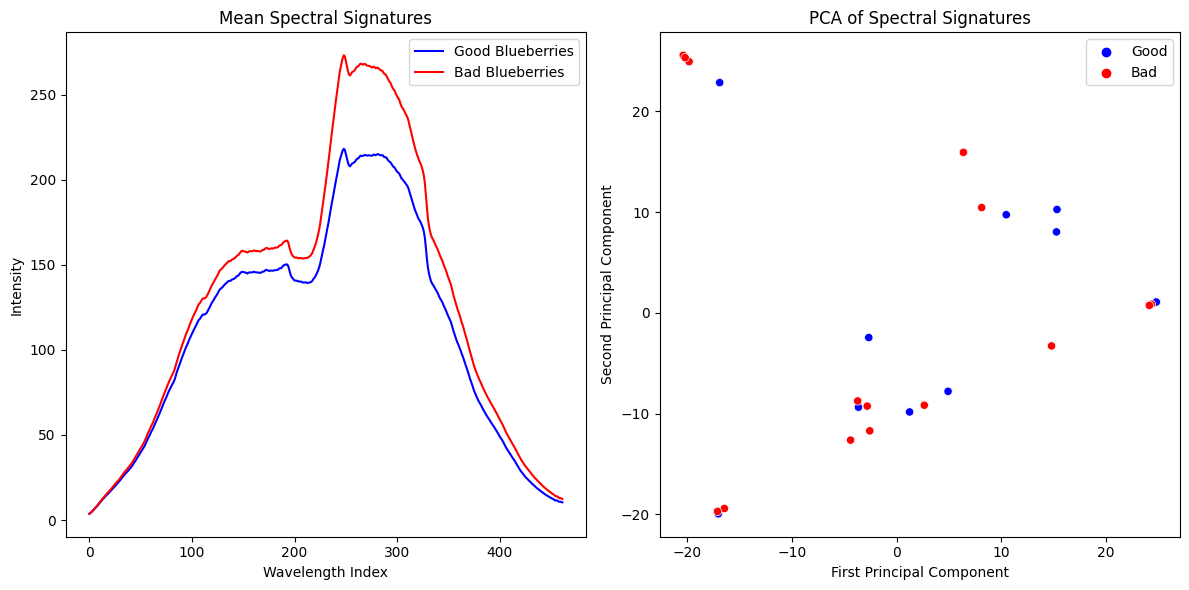

Saving results...
Analysis complete!


In [9]:
# Main execution
if __name__ == "__main__":
    # Set the data path to your Kaggle input directory
    data_path = "/kaggle/input/hyperspectral-blueberries/"
    
    # Run the analysis
    print("Starting analysis...")
    results = analyze_baseline(data_path)
    
    # Visualize the results
    print("Generating visualizations...")
    visualize_results(results)
    
    # Save results to CSV for further analysis
    print("Saving results...")
    good_df = pd.DataFrame(results['good'])
    bad_df = pd.DataFrame(results['bad'])
    
    good_df.to_csv('good_blueberry_spectra.csv', index=False)
    bad_df.to_csv('bad_blueberry_spectra.csv', index=False)
    
    print("Analysis complete!")